In [122]:
from datetime import datetime
import urllib
from os import path
from glob import glob
import re
import tiletanic
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

Download publicly available Ookla speed data. See https://github.com/teamookla/ookla-open-data/blob/master/tutorials/aggregate_by_county_py.ipynb for URL formatting scheme. Using parquet file format instead of zipped shapefiles for speed (files are very large).

In [6]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/parquet/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_{service_type}_tiles.parquet"
    return url

In [84]:
for year in [2020, 2021]:
    for q in range(1, 5):
        for service_type in ['fixed', 'mobile']:
            file = f'ookla_{service_type}_{year}_q{q}.parquet'
            if not path.exists(file):
                try:
                    url = get_tile_url(service_type, year, q)
                    urllib.request.urlretrieve(url, file)
                    print(f'Retrieved {service_type} performance data for Q{q} {year}')
                except:
                    pass

Retrieved fixed performance data for Q3 2020
Retrieved mobile performance data for Q3 2020
Retrieved fixed performance data for Q4 2020
Retrieved mobile performance data for Q4 2020
Retrieved fixed performance data for Q1 2021
Retrieved mobile performance data for Q1 2021


See https://github.com/teamookla/ookla-open-data/blob/master/tutorials/filter_parquet_bounding_box.md for a similar filtering technique that avoids loading huge geopandas dataframes

In [49]:
tiler = tiletanic.tileschemes.WebMercator()
zoom = 16
nyc_quadkeys = {tiler.quadkey(tile) for geom in nyc_boros['geometry'] for tile in tiletanic.tilecover.cover_geometry(tiler, geom, zoom)}

<AxesSubplot:>

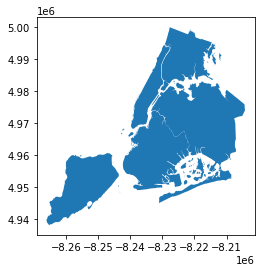

In [48]:
nyc_boros = gp.read_file('nybb_21a').to_crs(3857) #Web Mercator
nyc_boros.plot()

In [259]:
def nyc_tile_gdf(file):
    tiles = pd.read_parquet(file)
    nyc_tiles = tiles[tiles['quadkey'].isin(nyc_quadkeys)].copy()
    nyc_tiles['geometry'] = nyc_tiles['tile'].apply(wkt.loads)
    return gpd.GeoDataFrame(nyc_tiles, geometry='geometry').set_crs(4326)

<AxesSubplot:>

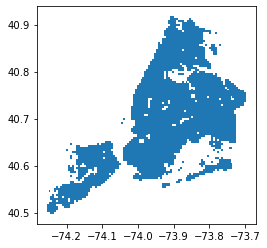

In [96]:
# check that everything looks alright
nyc_tile_gdf('ookla_fixed_2020_q1.parquet').plot()

Load the GeoDataFrames in into a dictionary of dictionaries

In [280]:
ookla = {}
p = re.compile(r'(20\d\d_q\d)')

for service_type in ['fixed', 'mobile']:
    files = glob(f'*{service_type}*.parquet')
    ookla[service_type] = {re.search(p, file).group(0): nyc_tile_gdf(file) for file in files}

Visualize the distribution of dowload and upload speeds to get reasonable cuts for further analysis

In [339]:
service_types = ['fixed', 'mobile']
speed_directions = ['down', 'up']

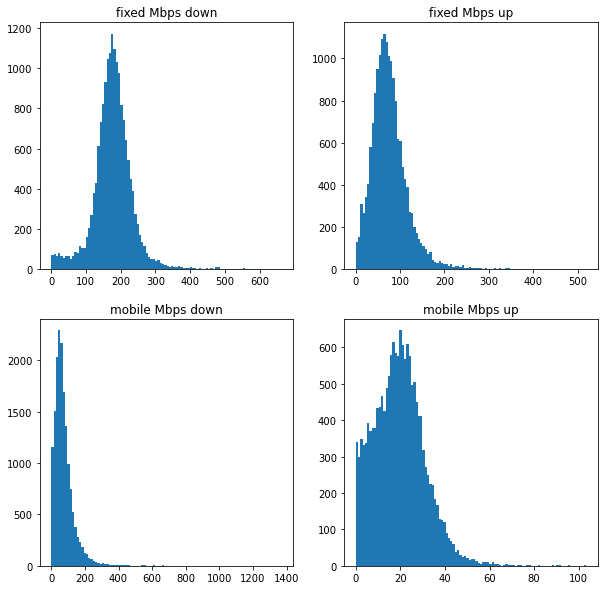

In [340]:
figure, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Average speeds across all quarters')

for i, service_type in enumerate(service_types):
    ookla_s = ookla[service_type].values() #list of geodataframes
    
    for j, speed_direction in enumerate(speed_directions):
        col = f'avg_{speed_direction[0]}_kbps'
        mbps = [kbps / 1000 for ookla_q in ookla_s for kbps in ookla_q[col]]
        
        axes[i, j].set_title(f'{service_type} Mbps {speed_direction}')
        axes[i, j].hist(mbps, bins=100)

In [341]:
# FTC defines broadband as 25 Mbps down, 3 Mbps up
breaks = {'down': [0, 25, 50, 100, 200, 1e3],
          'up': [0, 3, 6, 12, 24, 48, 1e3]}

Visualize the spatial distribution of speeds

In [330]:
speed_enum = enumerate(['down', 'up'])

In [342]:
def plot_tiles(service_type):
    ookla_s = ookla[service_type]
    fig, axes = plt.subplots(2, len(ookla_s), figsize=(15, 6), constrained_layout=True, subplot_kw={'aspect': 'equal'})

    fig.suptitle(f'Average {service_type} internet speeds (zoom {zoom} tiles)')
    fig.patch.set_visible(False)

    for i, speed_direction in enumerate(speed_directions):
        col = f'avg_{speed_direction[0]}_kbps'
            
        for j, quarter in enumerate(ookla_s.keys()):
            ookla_q = ookla_s[quarter]
            ookla_q = ookla_q[ookla_q['tests'] > 10].copy()
            ookla_q['mbps'] = pd.cut(ookla_q[col] / 1000, breaks[speed_direction])

            axes[i, j].set_title(quarter)
            axes[i, j].axis('off')
            ookla_q.plot(column='mbps', cmap="viridis", ax=axes[i, j], legend=(j == 0),
                         legend_kwds=dict(title=speed_direction, loc='upper left', bbox_to_anchor=(-.1, 1), frameon=False))

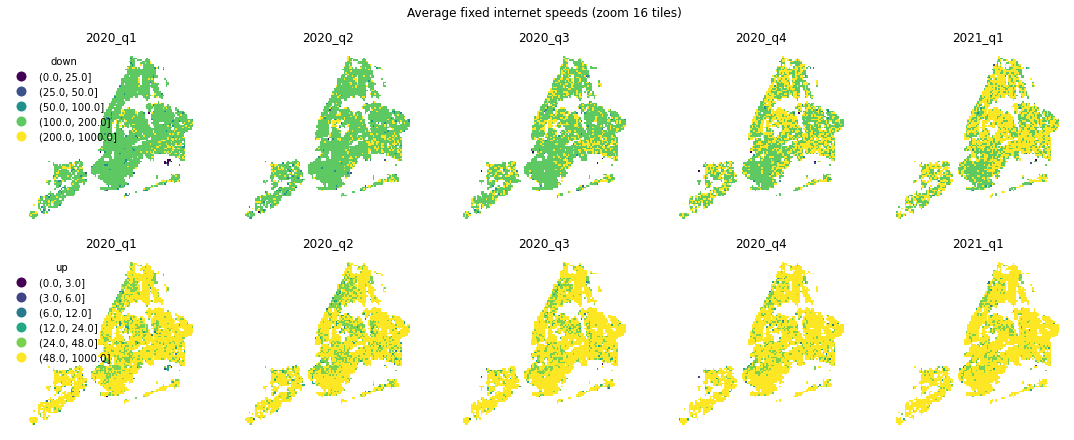

In [343]:
plot_tiles('fixed')

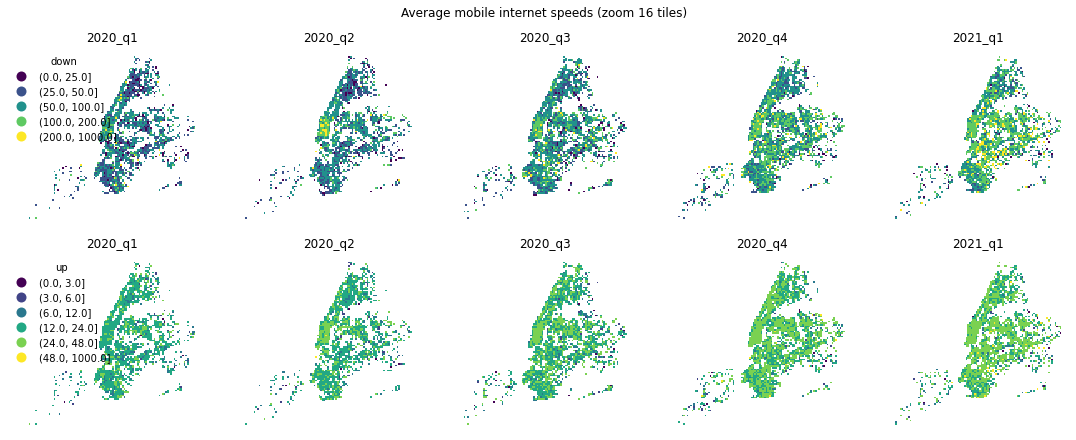

In [344]:
plot_tiles('mobile')